In [1]:
!pip install osmnx

In [2]:
import networkx as nx
import osmnx as ox

%matplotlib inline
ox.__version__

'1.1.2'

In [5]:
import pandas as pd

In [3]:
G = ox.graph_from_place("ile-de-france, France", network_type="drive")
#fig, ax = ox.plot_graph(G)

In [6]:
camping=pd.read_csv('camping.csv')
police=pd.read_csv('police.csv')

In [52]:
pd.set_option('display.max_rows', None)

In [ ]:
print(str(camping["geometry"]))

In [65]:
coordinates_camping=str(camping["geometry"]).split("\n")
coordinates_camping=coordinates_camping[:-1]
coordinates_police=str(police["geometry"]).split("\n")
coordinates_police=coordinates_police[:-1]

In [104]:
def get_coordinates(test):
  coordinates=[]
  for i in test:
    j=i.split('(')
    k=j[-1][:-1].split(" ")
    coordinates.append([float(k[0]),float(k[1])])
  return(coordinates)

In [ ]:
coordinates_camping_xy=get_coordinates(coordinates_camping)
coordinates_camping_xy

In [ ]:
coordinates_police_xy=get_coordinates(coordinates_police)
len(coordinates_police_xy)
coordinates_police_xy

In [146]:
def get_index(coordinates_police_xy,coordinates_camping_xy):
  i =coordinates_camping_xy
  neigh = NearestNeighbors(n_neighbors=1)
  neigh.fit(coordinates_police_xy)

  nearest=neigh.kneighbors([i])
  return(nearest[1][0][0])


In [150]:
def get_distance(start,end):
  distance=[]
  i=start
  dist=[]
  j=end[get_index(end,start)]
  orig = ox.distance.nearest_nodes(G, X=i[0], Y=i[1])
  dest = ox.distance.nearest_nodes(G, X=j[0] , Y=j[1])
  route = ox.shortest_path(G, orig, dest, weight="travel_time")
  #fig, ax = ox.plot_graph_route(G, route, node_size=0)
  edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
  dist.append(round(sum(edge_lengths)))
  distance = min(dist)
  return(distance)

In [156]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
distance_police=[]
index=0
for i in coordinates_camping_xy:
  index=index+1
  dist=get_distance(i,coordinates_police_xy)
  distance_police.append(dist)
  print(index,"/",len(coordinates_camping_xy)," finished")
camping["distance_police"]=distance_police

In [ ]:
camping

In [136]:
dist

2139

In [7]:
dist

6457

In [161]:
hopitaux=pd.read_csv("hopitaux.csv")
coordinates_hopitaux=str(hopitaux["geometry"]).split("\n")
coordinates_hopitaux=coordinates_hopitaux[:-1]
coordinates_hopitaux_xy=get_coordinates(coordinates_hopitaux)

In [162]:
distance_hopitaux=[]
index=0
for i in coordinates_camping_xy:
  index=index+1
  dist=get_distance(i,coordinates_hopitaux_xy)
  distance_hopitaux.append(dist)
  print(index,"/",len(coordinates_camping_xy)," finished")
camping["distance_hopitaux"]=distance_hopitaux

1 / 65  finished
2 / 65  finished
3 / 65  finished
4 / 65  finished
5 / 65  finished
6 / 65  finished
7 / 65  finished
8 / 65  finished
9 / 65  finished
10 / 65  finished
11 / 65  finished
12 / 65  finished
13 / 65  finished
14 / 65  finished
15 / 65  finished
16 / 65  finished
17 / 65  finished
18 / 65  finished
19 / 65  finished
20 / 65  finished
21 / 65  finished
22 / 65  finished
23 / 65  finished
24 / 65  finished
25 / 65  finished
26 / 65  finished
27 / 65  finished
28 / 65  finished
29 / 65  finished
30 / 65  finished
31 / 65  finished
32 / 65  finished
33 / 65  finished
34 / 65  finished
35 / 65  finished
36 / 65  finished
37 / 65  finished
38 / 65  finished
39 / 65  finished
40 / 65  finished
41 / 65  finished
42 / 65  finished
43 / 65  finished
44 / 65  finished
45 / 65  finished
46 / 65  finished
47 / 65  finished
48 / 65  finished
49 / 65  finished
50 / 65  finished
51 / 65  finished
52 / 65  finished
53 / 65  finished
54 / 65  finished
55 / 65  finished
56 / 65  finished
5

In [ ]:
camping

In [165]:
defibrillateurs=pd.read_csv("defibrillateur.csv")
coordinates_defibrillateurs=str(defibrillateurs["geometry"]).split("\n")
coordinates_defibrillateurs=coordinates_defibrillateurs[:-1]
coordinates_defibrillateurs_xy=get_coordinates(coordinates_defibrillateurs)

In [168]:
def get_distance2(start,end):
  distance=[]
  i=start
  dist=[]
  j=end[get_index(end,start)]
  orig = ox.distance.nearest_nodes(G, X=i[0], Y=i[1])
  dest = ox.distance.nearest_nodes(G, X=j[0] , Y=j[1])
  route = ox.shortest_path(G, orig, dest, weight="travel_time")
  #fig, ax = ox.plot_graph_route(G, route, node_size=0)
  edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
  dist.append(round(sum(edge_lengths)))
  return(dist)

In [179]:
distance_defibrillateurs=[]
index=0
for i in coordinates_camping_xy:
  index=index+1
  dist=get_distance2(i,coordinates_defibrillateurs_xy)
  num=sum(map(lambda x : x<2000, dist))
  distance_defibrillateurs.append(num)
  print(index,"/",len(coordinates_camping_xy)," finished")
camping["defib_moin_50m"]=distance_defibrillateurs

1 / 65  finished
2 / 65  finished
3 / 65  finished
4 / 65  finished
5 / 65  finished
6 / 65  finished
7 / 65  finished
8 / 65  finished
9 / 65  finished
10 / 65  finished
11 / 65  finished
12 / 65  finished
13 / 65  finished
14 / 65  finished
15 / 65  finished
16 / 65  finished
17 / 65  finished
18 / 65  finished
19 / 65  finished
20 / 65  finished
21 / 65  finished
22 / 65  finished
23 / 65  finished
24 / 65  finished
25 / 65  finished
26 / 65  finished
27 / 65  finished
28 / 65  finished
29 / 65  finished
30 / 65  finished
31 / 65  finished
32 / 65  finished
33 / 65  finished
34 / 65  finished
35 / 65  finished
36 / 65  finished
37 / 65  finished
38 / 65  finished
39 / 65  finished
40 / 65  finished
41 / 65  finished
42 / 65  finished
43 / 65  finished
44 / 65  finished
45 / 65  finished
46 / 65  finished
47 / 65  finished
48 / 65  finished
49 / 65  finished
50 / 65  finished
51 / 65  finished
52 / 65  finished
53 / 65  finished
54 / 65  finished
55 / 65  finished
56 / 65  finished
5

In [181]:
camping

,Unnamed: 0,Adresse_full,dep,Emplacements,Nom,Classement,commune,code_postal,geometry,Surface,type,distance_police,distance_hopitaux,defib_moin_50m
0,0,Route du Château d'eau,78,180,CAMPING HUTTOPIA RAMBOUILLET,3,RAMBOUILLET,78120,POINT (1.835694 48.630059),1.8000,camping,2817,6807,0
1,1,11 CHEMIN DU CAMPING,77,440,CAMPING LES PRÉS DE LA FONTAINE,3,HERMÉ,77114,POINT (3.338549 48.472784),4.4000,camping,4953,10485,1
2,2,26 Route de Vauvert,91,230,CARAVANING LE VAUVERT,4,ORMOY-LA-RIVIÈRE,91150,POINT (2.143939 48.411278),2.8750,camping,5177,691,1
3,3,chemin des ponceaux,77,140,CAMPING LES ACACIAS,2,BETON-BAZOCHES,77320,POINT (3.239464 48.707003),1.4000,camping,16466,23260,0
4,4,24 Place de la gare de Faremoutiers,77,316,LE CHÊNE GRIS,4,POMMEUSE,77515,POINT (2.99998 48.800512),3.9500,camping,8711,12013,1
5,5,Le Clos Gouget,78,100,CARAVANIG CLUB DU CLOS GOUGET,2,BOINVILLIERS,78200,POINT (1.661974 48.931593),1.0000,camping,9188,10804,0
6,6,49 Rue des Bondons,77,247,CARAVANING DES BONDONS,4,LA FERTÉ-SOUS-JOUARRE,77260,POINT (3.150584 48.948976),3.0875,camping,2139,23095,0
7,7,4 rue de l'ancienne église,77,44,BLP CARAVANING,1,PRÉCY-SUR-MARNE,77410,POINT (2.776459 48.930786),0.4400,camping,15316,19206,0
8,8,ROUTE DE LA PETITE BEAUCE,91,138,HÉLIOMONDE,3,SAINT-CHÉRON,91530,POINT (2.12983 48.53845),1.3800,camping,2703,30123,1
9,9,rue de montereau,77,84,CAMPING LE REFUGE,2,GRANDPUITS-BAILLY-CARROIS,77720,POINT (2.970295 48.583675),0.8400,camping,7179,38519,0


In [174]:
camping

,Unnamed: 0,Adresse_full,dep,Emplacements,Nom,Classement,commune,code_postal,geometry,Surface,type,distance_police,distance_hopitaux,defib_moin_50m
0,0,Route du Château d'eau,78,180,CAMPING HUTTOPIA RAMBOUILLET,3,RAMBOUILLET,78120,POINT (1.835694 48.630059),1.8000,camping,2817,6807,0
1,1,11 CHEMIN DU CAMPING,77,440,CAMPING LES PRÉS DE LA FONTAINE,3,HERMÉ,77114,POINT (3.338549 48.472784),4.4000,camping,4953,10485,0
2,2,26 Route de Vauvert,91,230,CARAVANING LE VAUVERT,4,ORMOY-LA-RIVIÈRE,91150,POINT (2.143939 48.411278),2.8750,camping,5177,691,0
3,3,chemin des ponceaux,77,140,CAMPING LES ACACIAS,2,BETON-BAZOCHES,77320,POINT (3.239464 48.707003),1.4000,camping,16466,23260,0
4,4,24 Place de la gare de Faremoutiers,77,316,LE CHÊNE GRIS,4,POMMEUSE,77515,POINT (2.99998 48.800512),3.9500,camping,8711,12013,1
5,5,Le Clos Gouget,78,100,CARAVANIG CLUB DU CLOS GOUGET,2,BOINVILLIERS,78200,POINT (1.661974 48.931593),1.0000,camping,9188,10804,0
6,6,49 Rue des Bondons,77,247,CARAVANING DES BONDONS,4,LA FERTÉ-SOUS-JOUARRE,77260,POINT (3.150584 48.948976),3.0875,camping,2139,23095,0
7,7,4 rue de l'ancienne église,77,44,BLP CARAVANING,1,PRÉCY-SUR-MARNE,77410,POINT (2.776459 48.930786),0.4400,camping,15316,19206,0
8,8,ROUTE DE LA PETITE BEAUCE,91,138,HÉLIOMONDE,3,SAINT-CHÉRON,91530,POINT (2.12983 48.53845),1.3800,camping,2703,30123,0
9,9,rue de montereau,77,84,CAMPING LE REFUGE,2,GRANDPUITS-BAILLY-CARROIS,77720,POINT (2.970295 48.583675),0.8400,camping,7179,38519,0


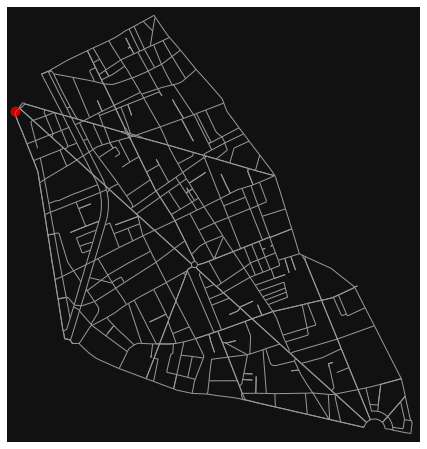

In [9]:
orig = ox.distance.nearest_nodes(G, X=2.27532, Y=48.86756)
dest = ox.distance.nearest_nodes(G, X=2.23466 , Y=48.86822)
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, "length")
dist=round(sum(edge_lengths))